In [1]:
import pandas as pd
import numpy as np

import re
import os
import glob

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms

from torch.utils.data import Dataset

from tqdm import tqdm
import torch.optim as optim

from torch.utils.data import DataLoader

from focal_loss.focal_loss import FocalLoss

import matplotlib.pyplot as plt

/home/jan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
# train_data_files = glob.glob(os.path.join("../data/train_thetas_means_and_confidence/", "*.csv"))
train_data_files = glob.glob(os.path.join("../data/train_thetas/", "*.csv"))
train_data_files.sort(key=lambda f: int(re.sub('\D', '', f)))
train_data = [torch.from_numpy(pd.read_csv(f, header=None, sep=',').to_numpy().flatten(order="F").reshape(2, 40, 40)).float()
               for f in train_data_files]# shape 15000 * (2, 40, 40)

target_train_files = glob.glob(os.path.join("../data/training_ground_truth_files", "*_ground"))
target_train_files.sort(key=lambda f: int(re.sub('\D', '', f)))
target_train = [torch.from_numpy(pd.read_csv(f, header=None, sep=' ').to_numpy()).long()
                 for f in target_train_files] # shape 15000 * (40, 40)

# test_data_files = glob.glob(os.path.join("../data/test_thetas_means_and_confidence/", "*.csv"))
test_data_files = glob.glob(os.path.join("../data/test_thetas/", "*.csv"))
test_data_files.sort(key=lambda f: int(re.sub('\D', '', f)))
test_data = [torch.from_numpy(pd.read_csv(f, header=None, sep=',').to_numpy().flatten(order="F").reshape(2, 40, 40)).float()
               for f in test_data_files]# shape 15000 * (2, 40, 40)

In [3]:
print("train_data shape: ", len(train_data))
print("target_train shape: ", len(target_train))

train_data shape:  15000
target_train shape:  15000


In [4]:
# train_data = train_data[:1000]
# target_train = target_train[:1000]

In [5]:
# split train_data into train and validation
X_train, X_val, y_train, y_val = train_test_split(train_data, target_train, test_size=0.2, random_state=42)

In [6]:
def aIOU(predictions, gt):
    classes = np.unique(np.concatenate((np.unique(predictions), np.unique(gt))))
    IoUs = np.zeros(len(classes) - 1)
    i = 0
    for cls in classes:
        if cls != 0:
            preds_tmp = predictions == cls
            gt_tmp = gt == cls
            IoUs[i] = np.sum(np.logical_and(preds_tmp, gt_tmp)) / np.sum(np.logical_or(preds_tmp, gt_tmp))
            i += 1
    return np.mean(IoUs)

In [7]:
# UNET

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=2, out_channels=22, features=[40, 80, 160, 320],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        x = torch.softmax(x, dim=1)
        # permute to have channels as last dimension
        return x.permute(0, 2, 3, 1).contiguous()

In [8]:
def augment_rotate(X, y):
    X_aug = []
    y_aug = []
    for i in range(len(X)):
        for rotation in range(4):
            X_aug.append(torch.rot90(X[i], rotation, [1, 2]))
            y_aug.append(torch.rot90(y[i], rotation, [0, 1]))
    return X_aug, y_aug


def augment_flip(X, y):
    X_aug = []
    y_aug = []
    for i in range(len(X)):
        X_aug.append(X[i])
        y_aug.append(y[i])
        X_aug.append(torch.flip(X[i], [1]))
        y_aug.append(torch.flip(y[i], [0]))
    return X_aug, y_aug


def augment_roll(X, y):
    X_aug = []
    y_aug = []
    for i in range(len(X)):
        for roll_x in range(0, 2):
            for roll_y in range(0, 2):
                X_aug.append(torch.roll(X[i], shifts=(roll_x, roll_y), dims=(1, 2)))
                y_aug.append(torch.roll(y[i], shifts=(roll_x, roll_y), dims=(0, 1)))
    return X_aug, y_aug


def augment_data(X, y):
    X_roll, y_roll = augment_roll(X, y)
    X_roll_flip, y_roll_flip = augment_flip(X_roll, y_roll)
    X_roll_flip_rotate, y_roll_flip_rotate = augment_rotate(X_roll_flip, y_roll_flip)
    return X_roll_flip_rotate, y_roll_flip_rotate

In [9]:

class MuonDataset(Dataset):
    def __init__(self, x, y, transform):
        self.transform = transform
        self.x=x
        self.y=y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x_idx = self.x[index]
        y_idx = self.y[index]

        if self.transform:
                x_idx=self.transform(x_idx)
        return x_idx, y_idx

In [10]:
class MuonTestDataset(Dataset):
    def __init__(self, x, transform):
        self.transform = transform
        self.x=x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x_idx = self.x[index]

        if self.transform:
                x_idx=self.transform(x_idx)
        return x_idx

In [11]:
def get_loaders(
    batch_size,
    train_transforms,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    X_train_aug, y_train_aug = augment_data(X_train, y_train)
    train_ds = MuonDataset(
        x=X_train_aug,
        y=y_train_aug,
        transform=train_transforms,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = MuonDataset(
        x=X_val,
        y=y_val,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    test_ds = MuonTestDataset(
        x=test_data,
        transform=val_transform,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

In [12]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print device
print(DEVICE)
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_WORKERS = 2
PIN_MEMORY = True

cuda


In [13]:

def train_function(data, model, optimizer, loss_fn):
    print('Entering into train function')
    loss_values = []    
    data = tqdm(data)    
    for index, (X, y) in enumerate(data):              
        X, y = X.to(DEVICE), y.to(DEVICE)        
        preds = model(X)  
          
        loss = loss_fn(preds, y)        
        optimizer.zero_grad()        
        loss.backward()        
        optimizer.step()  
   
    return loss.item()

In [14]:
train_transforms = transforms.Compose(
    [
        transforms.Normalize(
        mean=[0.0, 0.0],
        std=[1.0, 1.0],
        ),
    ]
)

val_transforms = transforms.Compose(
        [
                transforms.Normalize(
                mean=[0.0, 0.0],
                std=[1.0, 1.0],
                ),
        ]
)

test_transforms = transforms.Compose(
        [
                transforms.Normalize(
                mean=[0.0, 0.0],
                std=[1.0, 1.0],
                ),
        ]
)

model = UNET(in_channels=2, out_channels=22).to(DEVICE)
loss_fn = FocalLoss(gamma=2)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader, test_loader = get_loaders(
        BATCH_SIZE,
        train_transforms,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
)

In [15]:
for epoch in range(NUM_EPOCHS):
        loss = train_function(train_loader, model, optimizer, loss_fn)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, loss={loss}")

Entering into train function


100%|██████████| 12000/12000 [06:41<00:00, 29.87it/s]


Epoch 1/5, loss=0.04756266996264458
Entering into train function


100%|██████████| 12000/12000 [07:34<00:00, 26.42it/s]


Epoch 2/5, loss=0.04282934218645096
Entering into train function


100%|██████████| 12000/12000 [08:05<00:00, 24.72it/s]


Epoch 3/5, loss=0.04517347365617752
Entering into train function


100%|██████████| 12000/12000 [08:02<00:00, 24.88it/s]


Epoch 4/5, loss=0.03648411110043526
Entering into train function


100%|██████████| 12000/12000 [07:15<00:00, 27.53it/s]

Epoch 5/5, loss=0.0343795046210289


In [16]:
def output_transform(output):
    # change output to 1D tensor
    # first pick max value for each pixel over channels
    # then flatten to 1d
    output = torch.argmax(output, dim=-1)
    return output.flatten().cpu().numpy()


In [17]:
def eval():
   # use val_loader
   model.eval()
   with torch.no_grad():
         for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            output = output_transform(output)
            target = target.flatten().cpu().numpy()
            aiou_list = []
            aiou_list.append(aIOU(output, target))
         aIou = np.mean(aiou_list)
         print('IOU: ', aIou)

In [18]:
eval()

IOU:  0.49297009035236916


In [19]:
def pred_test():
    model.eval()
    with torch.no_grad():
        result = []
        for batch_idx, (data) in enumerate(test_loader):
            data = data.to(DEVICE)
            output = model(data)
            output = output_transform(output)
            result.append(output)
        return result

In [20]:
preds = pred_test()
preds_out = np.concatenate(preds, axis=0).reshape(-1, 40, 40)
preds_out = preds_out.transpose(0, 2, 1).reshape(-1, 1600) # permute so that y_values are consecutive
print(preds_out.shape)

(5000, 1600)


In [21]:
# save preds_out to csv
df = pd.DataFrame(preds_out)
df.to_csv('isect_weight_line_mean_conf_rollaug.csv', index=False, header=False)

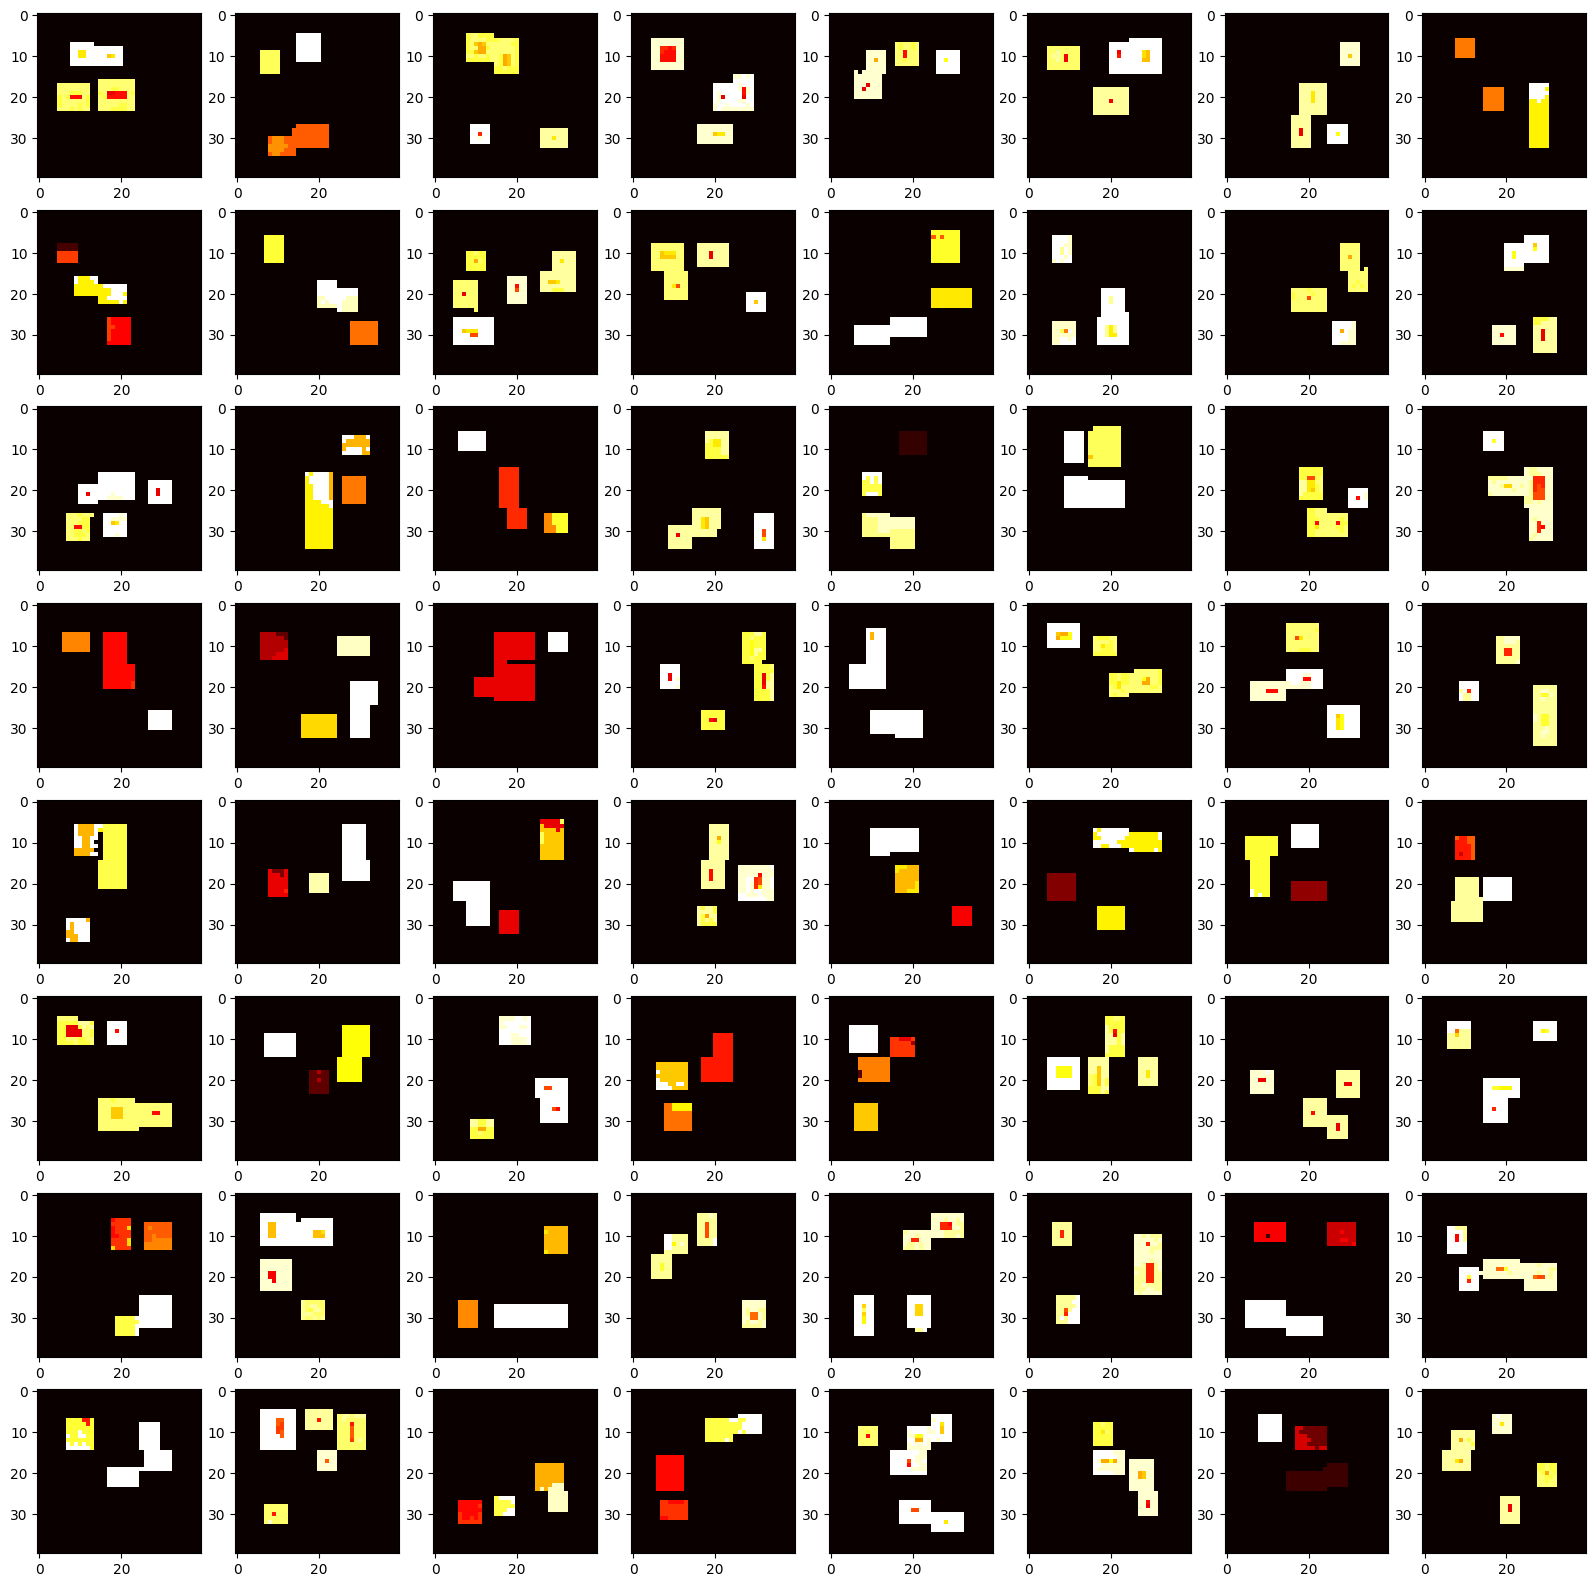

In [22]:
preds_vis = preds_out.reshape(-1, 40, 40)[:64]

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(preds_vis[i], cmap='hot', interpolation='nearest')
    # ax.set_title(random_files[i])

plt.show()